In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import time
import os
import torch

from datasets.mnist import MNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from cem3 import ContrastiveExplanationMethod

# set random seeds for reproducability (although the CEM is fully determininstic)
torch.manual_seed(0)
np.random.seed(0)

In [2]:
dataset = MNIST(batch_size=64)
# dataset = FashionMNIST()

# Training the classifier

In [3]:
cnn = CNN(device="cpu")

train_cnn(cnn, dataset, iterations=20, lr=0.01, save_fn='mnist-cnn', device="cpu", load_path="models/saved_models/mnist-cnn.h5")

In [4]:
images, _ = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.detach().numpy()


D:\david\Coding\uva-fact-ai\models\conv_model.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


In [5]:
# # evaluate the cnn by uncommenting this cell

# total_acc = 0
# total_batches = 0
# for step, (batch_inputs, batch_targets) in enumerate(dataset.test_loader):
    
#     predictions = cnn(batch_inputs)
#     acc = (predictions.argmax(1).cpu().numpy() == batch_targets.cpu().numpy()).sum()/(predictions.shape[0] )
#     total_batches += 1
#     total_acc += acc
    
# print("acc: {}".format(total_acc / total_batches))

# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [6]:
# Train or load autoencoder
cae = CAE(device="cpu")

train_ae(cae, dataset, iterations=10, save_fn="mnist-cae", device="cpu", load_path="models/saved_models/mnist-cae-no-rs.h5")

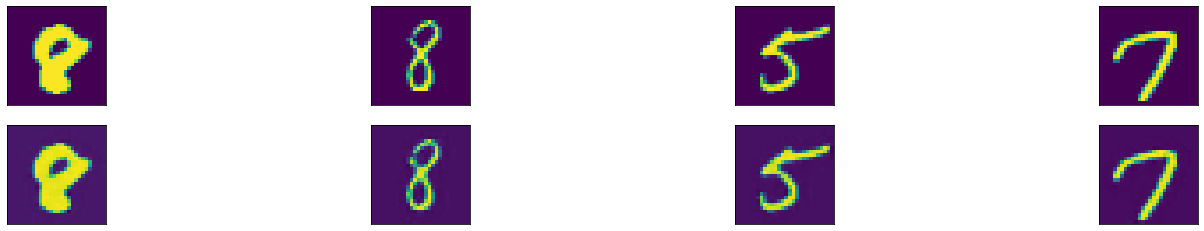

In [7]:
# obtain one batch of test images
images, _ = dataset.get_batch()

images += 0.5

#images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = cae(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [12]:
# optimal: kappa 30, gamma 1.0, beta 0.1, lr 0.01

kappa = 30
gamma = 1.0
beta = 0.1
lr = 0.01
CEM = ContrastiveExplanationMethod(
    cnn,
    cae,
    iterations=1000,
    n_searches=9,
    kappa=kappa,
    gamma=gamma,
    beta=beta,
    learning_rate=lr,
    c_init=10.0
)

In [13]:
def save_imgs():
    # save the created images
    dirname = "saved_perturbations/mode-{}-kappa-{}-gamma-{}-beta-{}-lr-{}".format(mode, kappa, gamma, beta, lr)
    os.makedirs(dirname, exist_ok=True)
    
    fname_orig = dirname + "/{}-cb-{}-ca-{}-orig.png".format(int(time.time()), before, after)
    fname_pert = dirname + "/{}-before-{}-after-{}-pert.png".format(int(time.time()), before, after)
    fname_combined = dirname + "/{}-before-{}-after-{}-pn.png".format(int(time.time()), before, after)
    fname_combined_pp = dirname + "/{}-before-{}-after-{}-pp.png".format(int(time.time()), before, after)
    
    plt.imsave(fname_orig, image.squeeze(), cmap="gray")
    plt.imsave(fname_pert, CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
    plt.imsave(fname_combined, CEM.best_delta.view(28,28), cmap="gray")
    plt.imsave(fname_combined_pp, image.squeeze() - CEM.best_delta.view(28,28), cmap="gray")

In [14]:
for i in range(10):
    # obtain one sample
    image = dataset.get_sample_by_class(class_label=i, show_image=False)

    print("IMAGE FROM CLASS: {}".format(i))
    before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
    
    for mode in ["PP", "PN"]:
        
        CEM.fista(image, mode=mode)
        
        if mode == "PP":
            after = after = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
        else:
            after = np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach()).item()
        
        save_imgs()

IMAGE FROM CLASS: 0
search: 0 iteration: 500 c: 10.0 loss: 326.42 found optimum: False
search: 0 iteration: 1000 c: 10.0 loss: 343.90 found optimum: False
new best: 120.96009063720703
new best: 100.87069702148438
new best: 94.95941925048828
new best: 91.664306640625
new best: 87.99156188964844
new best: 86.84324645996094
search: 1 iteration: 500 c: 100.0 loss: 202.08 found optimum: True
new best: 85.16813659667969
new best: 81.86997985839844
search: 1 iteration: 1000 c: 100.0 loss: 2553.09 found optimum: True
search: 2 iteration: 500 c: 50.05 loss: 96.09 found optimum: True
new best: 78.644775390625
search: 2 iteration: 1000 c: 50.05 loss: 1551.57 found optimum: True
new best: 77.70014953613281
new best: 77.35545349121094
new best: 77.2851791381836
search: 3 iteration: 500 c: 25.075 loss: 389.23 found optimum: True
search: 3 iteration: 1000 c: 25.075 loss: 798.47 found optimum: True
search: 4 iteration: 500 c: 12.5875 loss: 303.29 found optimum: True
search: 4 iteration: 1000 c: 12.587

search: 2 iteration: 500 c: 50.05 loss: 85.85 found optimum: True
new best: 77.79278564453125
search: 2 iteration: 1000 c: 50.05 loss: 1547.30 found optimum: True
new best: 76.76705932617188
search: 3 iteration: 500 c: 25.075 loss: 128.47 found optimum: True
search: 3 iteration: 1000 c: 25.075 loss: 796.34 found optimum: True
new best: 76.3530502319336
search: 4 iteration: 500 c: 12.5875 loss: 279.36 found optimum: True
search: 4 iteration: 1000 c: 12.5875 loss: 420.85 found optimum: True
search: 5 iteration: 500 c: 6.34375 loss: 233.11 found optimum: False
search: 5 iteration: 1000 c: 6.34375 loss: 233.11 found optimum: False
search: 6 iteration: 500 c: 63.4375 loss: 88.64 found optimum: True
search: 6 iteration: 1000 c: 63.4375 loss: 1898.83 found optimum: True
search: 7 iteration: 500 c: 31.76875 loss: 340.60 found optimum: True
search: 7 iteration: 1000 c: 31.76875 loss: 997.61 found optimum: True
search: 8 iteration: 500 c: 15.934375000000001 loss: 223.58 found optimum: True
searc

new best: 75.34761047363281
search: 3 iteration: 500 c: 25.075 loss: 271.18 found optimum: True
search: 3 iteration: 1000 c: 25.075 loss: 796.98 found optimum: True
search: 4 iteration: 500 c: 12.5875 loss: 191.12 found optimum: False
search: 4 iteration: 1000 c: 12.5875 loss: 421.18 found optimum: False
search: 5 iteration: 500 c: 125.875 loss: 2056.10 found optimum: True
search: 5 iteration: 1000 c: 125.875 loss: 1592.24 found optimum: True
search: 6 iteration: 500 c: 62.9875 loss: 779.96 found optimum: True
search: 6 iteration: 1000 c: 62.9875 loss: 1498.58 found optimum: True
new best: 75.18296813964844
search: 7 iteration: 500 c: 31.54375 loss: 285.61 found optimum: True
search: 7 iteration: 1000 c: 31.54375 loss: 991.65 found optimum: True
search: 8 iteration: 500 c: 15.821875 loss: 170.25 found optimum: False
search: 8 iteration: 1000 c: 15.821875 loss: 518.51 found optimum: False
search: 0 iteration: 500 c: 10.0 loss: 302.58 found optimum: False
search: 0 iteration: 1000 c: 10.

new best: 104.83263397216797
new best: 91.36865997314453
search: 3 iteration: 500 c: 500.5 loss: 163.19 found optimum: True
new best: 89.21900177001953
new best: 86.49449920654297
new best: 83.14783477783203
new best: 78.14935302734375
new best: 73.40339660644531
search: 3 iteration: 1000 c: 500.5 loss: 1302.43 found optimum: True
search: 4 iteration: 500 c: 250.3 loss: 117.45 found optimum: True
new best: 72.42637634277344
new best: 72.23590087890625
new best: 72.10900115966797
new best: 71.53779602050781
new best: 70.2624282836914
new best: 69.96275329589844
new best: 69.4828872680664
search: 4 iteration: 1000 c: 250.3 loss: 1192.51 found optimum: True
new best: 68.95878601074219
new best: 68.60835266113281
new best: 68.55768585205078
new best: 68.3712158203125
new best: 68.35772705078125
new best: 68.06221008300781
new best: 67.70252227783203
new best: 67.48957061767578
new best: 67.44237518310547
new best: 67.32306671142578
new best: 67.21389770507812
new best: 67.05887603759766
ne

search: 2 iteration: 500 c: 50.05 loss: 281.28 found optimum: False
search: 2 iteration: 1000 c: 50.05 loss: 1573.86 found optimum: False
new best: 99.11260986328125
new best: 92.6505126953125
search: 3 iteration: 500 c: 500.5 loss: 136.08 found optimum: True
new best: 92.39713287353516
new best: 90.90373992919922
new best: 89.14472198486328
new best: 88.56207275390625
new best: 86.82327270507812
new best: 86.72612762451172
new best: 85.37324523925781
new best: 84.75202941894531
new best: 83.95320129394531
new best: 82.92184448242188
new best: 82.72726440429688
new best: 80.97838592529297
new best: 80.11632537841797
new best: 78.40177154541016
new best: 77.38555145263672
new best: 75.80413818359375
new best: 74.93317413330078
new best: 73.11981964111328
new best: 71.93565368652344
new best: 70.16256713867188
new best: 69.94031524658203
new best: 68.70464324951172
new best: 68.49854278564453
new best: 66.71379089355469
new best: 64.89114379882812
new best: 62.8815803527832
new best: 61.

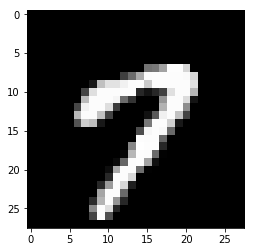

classification before perturbation: 7


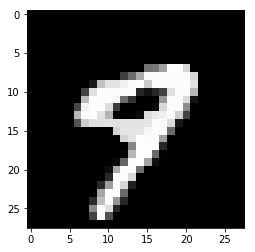

classification after perturbation: 9


In [59]:
# print original image
plt.imshow(image.view(28,28), cmap="gray")
plt.show()

# classification before
before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
print("classification before perturbation: {}".format(before))

if mode == "PP":
    plt.imshow(image.squeeze() - CEM.best_delta.view(28,28), cmap="gray")
    plt.show()
    after = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
    print("classification of delta: {}".format(after))
else:
    plt.imshow(CEM.best_delta.view(28,28),  cmap="gray")
    plt.show()
    after = np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach()).item()
    print("classification after perturbation: {}".format(after))